In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV,StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from scipy.stats import uniform, loguniform
from sklearn.pipeline import Pipeline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib
import time

2025-05-19 19:41:01.419196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747683661.622155      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747683661.681543      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading Dataset**

In [2]:
# Load data in chunks to manage memory
chunk_size = 100000
chunks = pd.read_json("/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json", lines=True, chunksize=chunk_size)
df = pd.concat(chunks, ignore_index=True)

In [3]:
df.shape

(2735264, 14)

# **Data Exploration and Visualization**

## **Data Inspection**

In [4]:
print("Shape of dataset:", df.shape,'\n')
print("info about dataset: ",df.info(),"\n")
print("\nMissing values:\n", df.isnull().sum())

Shape of dataset: (2735264, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2735264 entries, 0 to 2735263
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   submitter       object
 2   authors         object
 3   title           object
 4   comments        object
 5   journal-ref     object
 6   doi             object
 7   report-no       object
 8   categories      object
 9   license         object
 10  abstract        object
 11  versions        object
 12  update_date     object
 13  authors_parsed  object
dtypes: object(14)
memory usage: 292.2+ MB
info about dataset:  None 


Missing values:
 id                      0
submitter           15189
authors                 0
title                   0
comments           713227
journal-ref       1842970
doi               1494843
report-no         2550013
categories              0
license            452782
abstract                0
versions                0
upda

## **Visualization**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


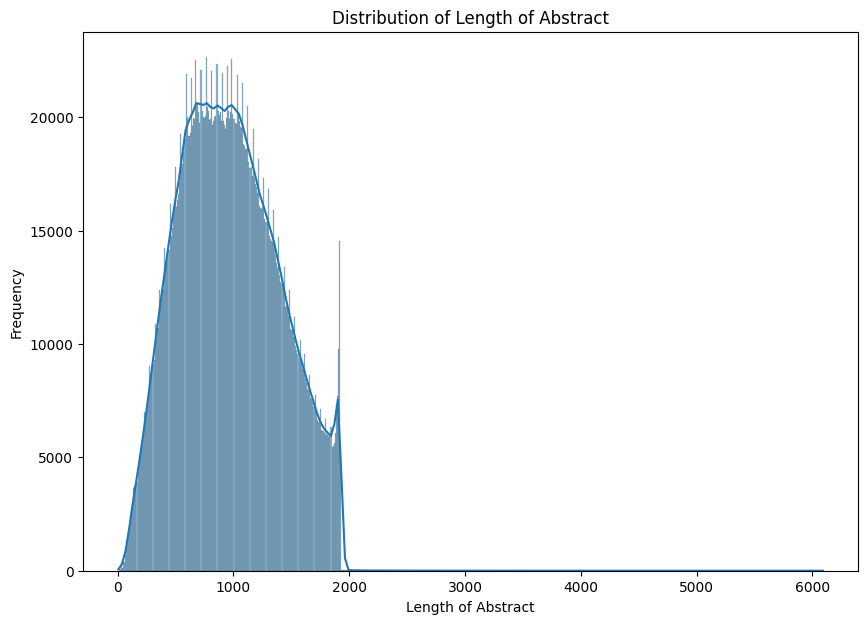

In [5]:
# get Lenth of Text.
df['len_text'] = df['abstract'].apply(len)
df['len_text'].head()

plt.figure(figsize=(10, 7))  # Corrected from "figuer" to "figure"
plt.title("Distribution of Length of Abstract")  # Fixed spelling of "Distrbution" and "Lenth"
sns.histplot(df['len_text'], kde=True)  # Pass just the Series, not x=df['len_text']
plt.xlabel("Length of Abstract")
plt.ylabel("Frequency")
plt.show()

## **Check Balance**

In [6]:
fillter = df['categories'].value_counts()

In [7]:
dfff = df.copy()

In [8]:
def balance_data(df, filter_counts):
    valid_categories = [cat for cat, count in filter_counts.items() if  count > 10000]
    return df[df['categories'].isin(valid_categories)]

In [9]:
dff = balance_data(df,fillter)
df= dff
dff.shape

(1246053, 15)

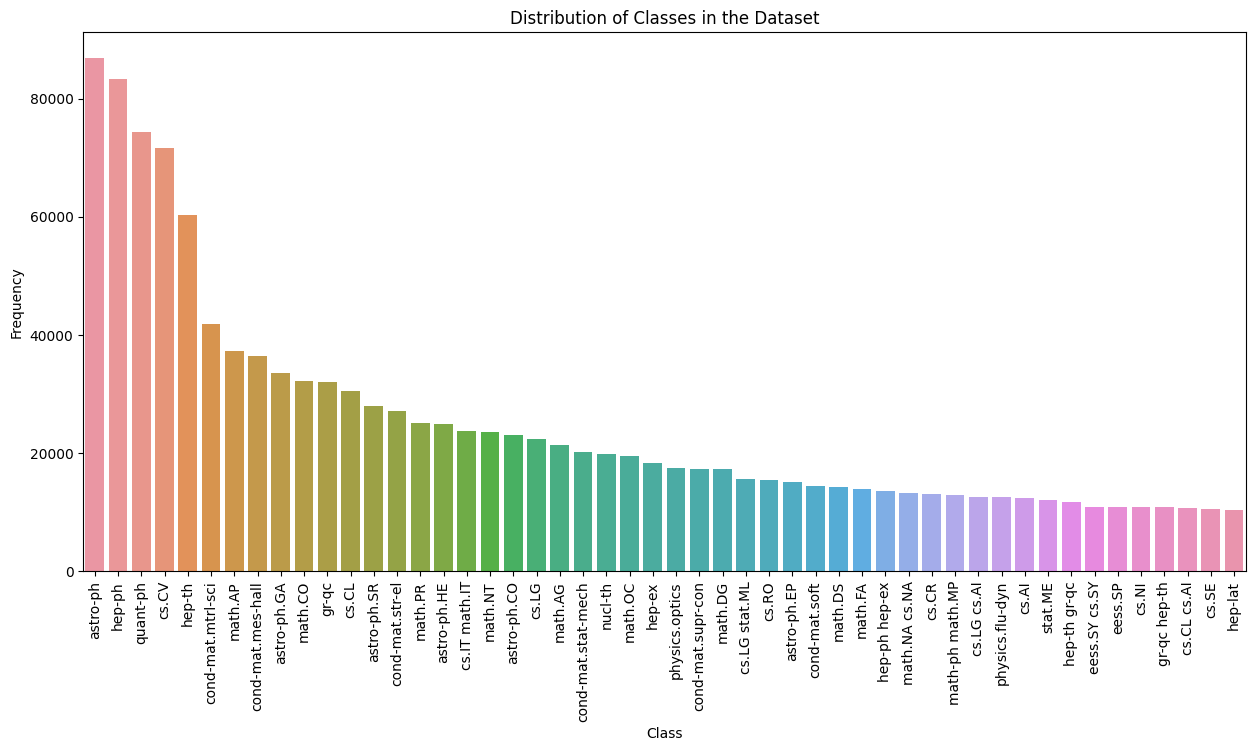

In [10]:
#Distribution of Class of Dataset.

plt.figure(figsize=(15, 7))
plt.title("Distribution of Classes in the Dataset")
sns.countplot(data=df, x='categories', order=df['categories'].value_counts().index)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

## **Word cloud**

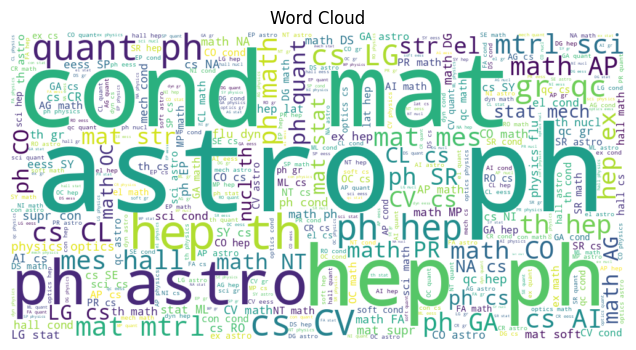

In [11]:
from wordcloud import WordCloud

all_text = ' '.join(df['categories'])

wordcloud = WordCloud(width=1000, height=500, background_color='white', max_words=1000).generate(all_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [12]:
print("Shape of dataset:", df.shape,'\n')
print("info about dataset: ",df.info(),"\n")
print("\nMissing values:\n", df.isnull().sum())

Shape of dataset: (1246053, 15) 

<class 'pandas.core.frame.DataFrame'>
Index: 1246053 entries, 0 to 2734350
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1246053 non-null  object
 1   submitter       1235579 non-null  object
 2   authors         1246053 non-null  object
 3   title           1246053 non-null  object
 4   comments        952355 non-null   object
 5   journal-ref     430324 non-null   object
 6   doi             617528 non-null   object
 7   report-no       107918 non-null   object
 8   categories      1246053 non-null  object
 9   license         969148 non-null   object
 10  abstract        1246053 non-null  object
 11  versions        1246053 non-null  object
 12  update_date     1246053 non-null  object
 13  authors_parsed  1246053 non-null  object
 14  len_text        1246053 non-null  int64 
dtypes: int64(1), object(14)
memory usage: 152.1+ MB
info about dataset:  No

# **Data Preprocessing**

## **Text Cleaning**

In [13]:
df.drop(['report-no','id','journal-ref','doi'], axis=1, inplace=True)
df['comments'].fillna('No Comments')
df['submitter'].fillna('Prefer not to say')
df['license'].fillna('None')

0                                                       None
3                                                       None
5                                                       None
6                                                       None
7          http://arxiv.org/licenses/nonexclusive-distrib...
                                 ...                        
2734345                                                 None
2734346                                                 None
2734348                                                 None
2734349                                                 None
2734350                                                 None
Name: license, Length: 1246053, dtype: object

In [14]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text

    text = re.sub(r'\W', ' ', str(text)) # Remove all the special characters from text

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [15]:
df['Cleaned_abstract'] = df['abstract'].apply(process_text)

In [16]:
X = df['Cleaned_abstract']
y = df['categories']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [18]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(df['abstract'], y, test_size=0.2, random_state=42,shuffle=True)

# **Feature Engineering**


In [19]:
X_train = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_train]
X_test = [' '.join(doc) if isinstance(doc, list) else doc for doc in X_test]

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


=== Logistic Regression ===
Accuracy: 0.7825537396021844
Classification Report:
                    precision    recall  f1-score   support

          astro-ph       0.70      0.78      0.74     17129
       astro-ph.CO       0.72      0.55      0.62      4572
       astro-ph.EP       0.87      0.87      0.87      3082
       astro-ph.GA       0.77      0.74      0.76      6865
       astro-ph.HE       0.79      0.72      0.75      4885
       astro-ph.SR       0.79      0.73      0.76      5606
 cond-mat.mes-hall       0.76      0.75      0.76      7184
 cond-mat.mtrl-sci       0.79      0.80      0.79      8522
     cond-mat.soft       0.79      0.78      0.78      2842
cond-mat.stat-mech       0.75      0.74      0.74      4123
   cond-mat.str-el       0.82      0.80      0.81      5399
 cond-mat.supr-con       0.88      0.84      0.86      3515
             cs.AI       0.63      0.58      0.60      2504
             cs.CL       0.69      0.87      0.77      5900
       cs.CL cs.AI

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Naive Bayes ===
Accuracy: 0.5040026323075627
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/em

                    precision    recall  f1-score   support

          astro-ph       0.36      0.97      0.53     17129
       astro-ph.CO       1.00      0.02      0.05      4572
       astro-ph.EP       0.95      0.02      0.04      3082
       astro-ph.GA       0.97      0.04      0.08      6865
       astro-ph.HE       1.00      0.01      0.01      4885
       astro-ph.SR       0.91      0.05      0.09      5606
 cond-mat.mes-hall       0.63      0.66      0.64      7184
 cond-mat.mtrl-sci       0.56      0.84      0.67      8522
     cond-mat.soft       0.91      0.12      0.21      2842
cond-mat.stat-mech       0.87      0.10      0.18      4123
   cond-mat.str-el       0.76      0.55      0.64      5399
 cond-mat.supr-con       0.98      0.12      0.21      3515
             cs.AI       1.00      0.00      0.01      2504
             cs.CL       0.73      0.39      0.51      5900
       cs.CL cs.AI       0.00      0.00      0.00      2129
             cs.CR       0.91      0.18

I0000 00:00:1747690684.219038      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1747690690.888228      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


6231/6231 ━━━━━━━━━━━━━━━━━━━━ 206s 32ms/step - accuracy: 0.2003 - loss: 2.9319 - val_accuracy: 0.6193 - val_loss: 1.1396
Epoch 2/20
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 198s 32ms/step - accuracy: 0.6355 - loss: 1.1232 - val_accuracy: 0.7210 - val_loss: 0.8343
Epoch 3/20
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 199s 32ms/step - accuracy: 0.7187 - loss: 0.8780 - val_accuracy: 0.7457 - val_loss: 0.7635
Epoch 4/20
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 199s 32ms/step - accuracy: 0.7486 - loss: 0.7825 - val_accuracy: 0.7573 - val_loss: 0.7264
Epoch 5/20
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 199s 32ms/step - accuracy: 0.7650 - loss: 0.7209 - val_accuracy: 0.7626 - val_loss: 0.7166
Epoch 6/20
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 198s 32ms/step - accuracy: 0.7778 - loss: 0.6774 - val_accuracy: 0.7640 - val_loss: 0.7132
Epoch 7/20
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 198s 32ms/step - accuracy: 0.7889 - loss: 0.6349 - val_accuracy: 0.7671 - val_loss: 0.7058
Epoch 8/20
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 198s 32ms/step - accuracy: 0.7983 - lo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Recurrent Neural Network (RNN) ===
Accuracy: 0.767153135294991
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

          astro-ph       0.73      0.79      0.76     17129
       astro-ph.CO       0.75      0.48      0.59      4572
       astro-ph.EP       0.88      0.84      0.86      3082
       astro-ph.GA       0.70      0.78      0.74      6865
       astro-ph.HE       0.75      0.76      0.76      4885
       astro-ph.SR       0.81      0.70      0.75      5606
 cond-mat.mes-hall       0.71      0.77      0.74      7184
 cond-mat.mtrl-sci       0.76      0.78      0.77      8522
     cond-mat.soft       0.73      0.76      0.74      2842
cond-mat.stat-mech       0.71      0.69      0.70      4123
   cond-mat.str-el       0.85      0.70      0.77      5399
 cond-mat.supr-con       0.86      0.86      0.86      3515
             cs.AI       0.63      0.53      0.57      2504
             cs.CL       0.67      0.92      0.77      5900
       cs.CL cs.AI       0.00      0.00      0.00      2129
             cs.CR       0.80      0.83

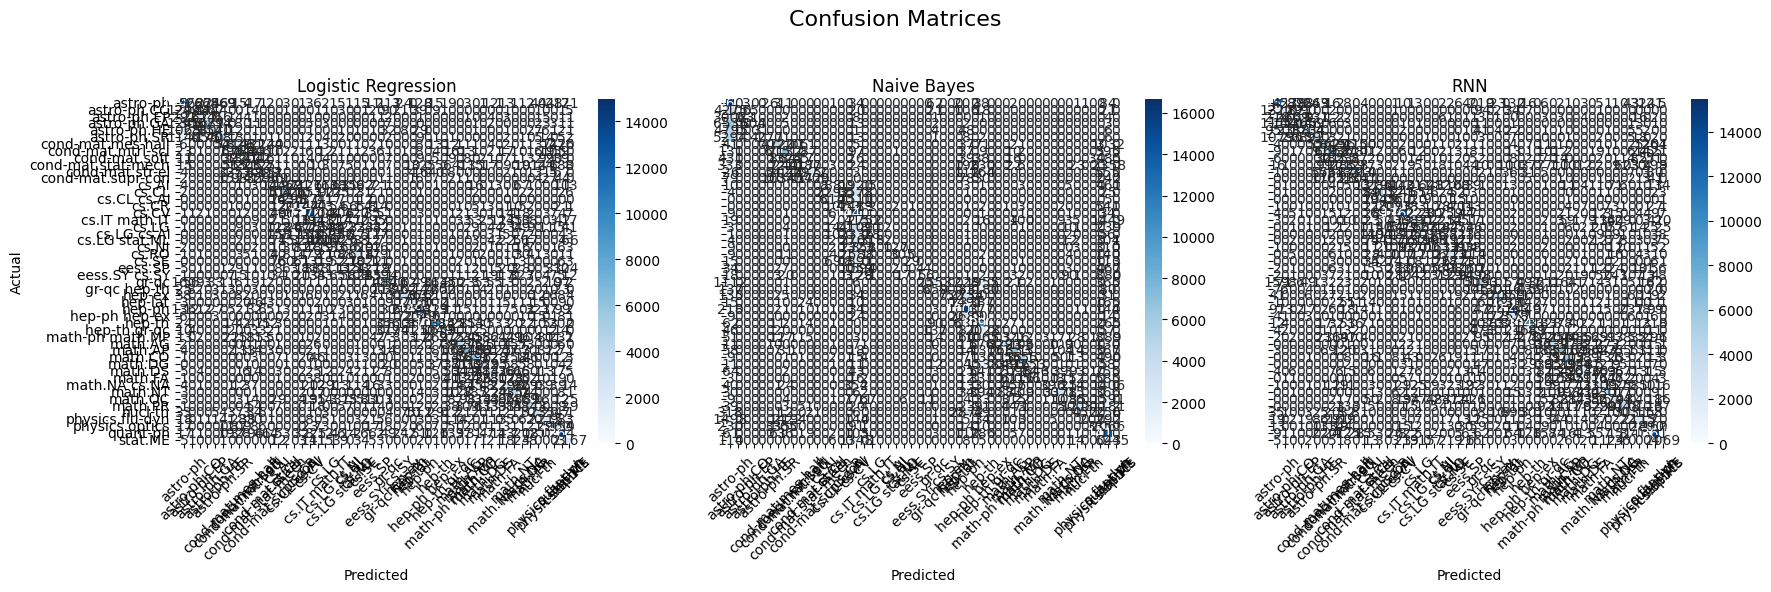

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


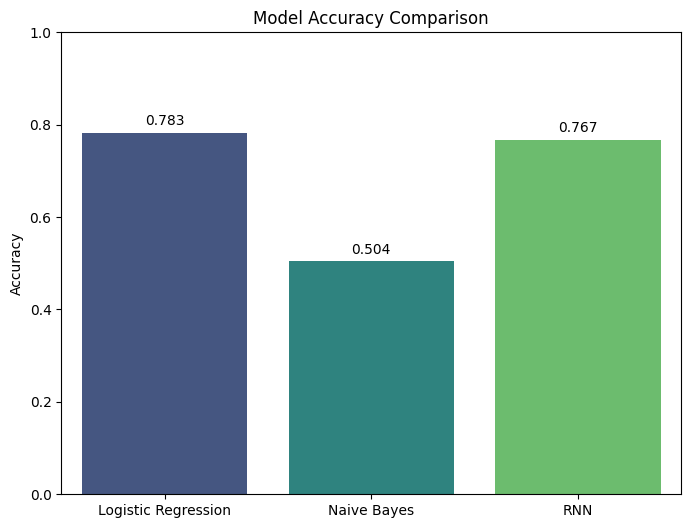

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


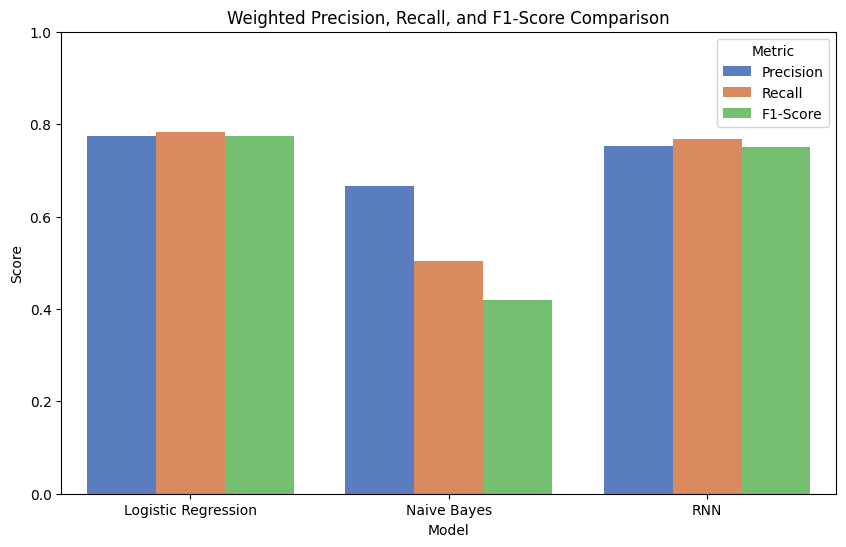

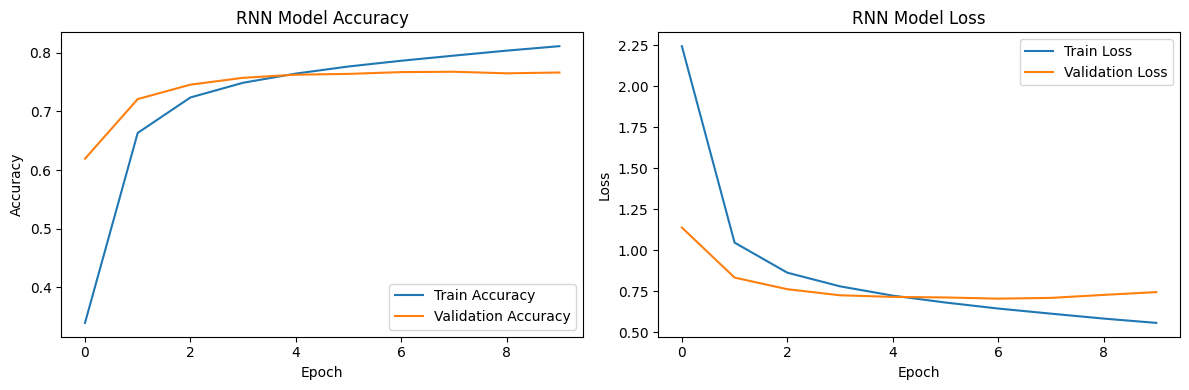

In [21]:
max_words = 10000
max_len = 200
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_rnn)
X_train_seq = tokenizer.texts_to_sequences(X_train_rnn)
X_test_seq = tokenizer.texts_to_sequences(X_test_rnn)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_rnn)
y_test_enc = label_encoder.transform(y_test_rnn)
num_classes = len(label_encoder.classes_)

joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# 5. Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_y_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_report = classification_report(y_test, lr_y_pred, output_dict=True)

print("\n=== Logistic Regression ===")
print("Accuracy:", lr_accuracy)
print("Classification Report:")
print(classification_report(y_test, lr_y_pred))

# 6. Train and evaluate Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_y_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_report = classification_report(y_test, nb_y_pred, output_dict=True)

print("\n=== Naive Bayes ===")
print("Accuracy:", nb_accuracy)
print("Classification Report:")
print(classification_report(y_test, nb_y_pred))

# 7. Train and evaluate RNN
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rnn_model.keras', monitor='val_accuracy', save_best_only=True)

# Train RNN
history = rnn_model.fit(
    X_train_pad,
    y_train_enc,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluate RNN
rnn_y_pred_prob = rnn_model.predict(X_test_pad)
rnn_y_pred_enc = np.argmax(rnn_y_pred_prob, axis=1)
rnn_y_pred = label_encoder.inverse_transform(rnn_y_pred_enc)
rnn_accuracy = accuracy_score(y_test_rnn, rnn_y_pred)
rnn_report = classification_report(y_test_rnn, rnn_y_pred, output_dict=True)

print("\n=== Recurrent Neural Network (RNN) ===")
print("Accuracy:", rnn_accuracy)
print("Classification Report:")
print(classification_report(y_test_rnn, rnn_y_pred))

# 8. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Confusion Matrices", fontsize=16)

# Logistic Regression
lr_cm = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].tick_params(axis='x', rotation=45)

# Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_pred)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[1].set_title("Naive Bayes")
axes[1].set_xlabel("Predicted")
axes[1].tick_params(axis='x', rotation=45)

# RNN
rnn_cm = confusion_matrix(y_test_rnn, rnn_y_pred)
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], 
            xticklabels=np.unique(y_test_rnn), yticklabels=np.unique(y_test_rnn))
axes[2].set_title("RNN")
axes[2].set_xlabel("Predicted")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 9. Bar Plot of Model Accuracies
model_names = ['Logistic Regression', 'Naive Bayes', 'RNN']
accuracies = [lr_accuracy, nb_accuracy, rnn_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', va='bottom')
plt.show()

# 10. Precision, Recall, F1-Score Bar Plot
lr_metrics = precision_recall_fscore_support(y_test, lr_y_pred, average='weighted')
nb_metrics = precision_recall_fscore_support(y_test, nb_y_pred, average='weighted')
rnn_metrics = precision_recall_fscore_support(y_test_rnn, rnn_y_pred, average='weighted')

metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'RNN'] * 3,
    'Metric': ['Precision'] * 3 + ['Recall'] * 3 + ['F1-Score'] * 3,
    'Score': [lr_metrics[0], nb_metrics[0], rnn_metrics[0],  # Precision
              lr_metrics[1], nb_metrics[1], rnn_metrics[1],  # Recall
              lr_metrics[2], nb_metrics[2], rnn_metrics[2]]  # F1-Score
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette='muted')
plt.title("Weighted Precision, Recall, and F1-Score Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()

# 11. Plot RNN training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save models
joblib.dump(lr_model, 'logistic_regression_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
rnn_model.save('rnn_model.keras')

In [22]:
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']